In [187]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import numpy
from tqdm import tqdm

In [188]:
#hyper params
num_epoch = 20
cuda_device = 0
batch_size = 140
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
input_ch = 1
# hidden_d = 512
hidden_d1 = 512
hidden_d2 = 256
hidden_d3 = 128
out_d = 10

In [189]:
torch.cuda.is_available()
# torch.cuda.empty_cache()

True

In [190]:
#model
class MyModelCNN(nn.Module):
    def __init__(self,
                 in_channels: int,
                 hidden_channels1: int,
                 hidden_channels2: int,
                 hidden_channels3: int,
                 n_classes: int,
                 ):
        super().__init__()
        # TODO change architecture

        # TODO use pooling
        self.pool = nn.AvgPool2d(kernel_size=3, padding=1, stride=1) # 140 * 1 * 28 * 28

        self.conv1 = nn.Conv2d(in_channels, hidden_channels1, kernel_size=5, padding=2, stride=2) # 140 * 1 * 14 * 14
        # TODO add batchnorm after each conv
        self.bn1 = nn.BatchNorm2d(hidden_channels1)     
                            # 512
        self.conv2 = nn.Conv2d(hidden_channels1, hidden_channels2, kernel_size=3, padding=1, stride=1) # 140 * 256 * 14 * 14
        self.bn2 = nn.BatchNorm2d(hidden_channels2)                         # 256
        
        self.conv3 = nn.Conv2d(hidden_channels2, hidden_channels3, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(hidden_channels3)                         # 128
        
        self.conv4 = nn.Conv2d(hidden_channels3, 1, kernel_size=1, padding=0, stride=1)
        # self.conv4 = nn.Conv2d(hidden_channels3, 14, kernel_size=1, padding=0, stride=1)
        self.linear1 = nn.Linear(14*14, n_classes, bias=True)

        self.activation = nn.ReLU()

    def forward(self, x):
        # print(f'before polling: {x.size()}')
        x = self.pool(x)
        # print(f'after polling: {x.size()}')
        y = self.activation(self.conv1(x))
        # print(f'before batch norm: {y.size()}')
        x = self.bn1(y)
        # x = self.activation(self.bn1(self.conv1(x)))
        # print(f'after 1 conv: {x.size()}')
        y = self.activation(self.conv2(x))
        # print(f'before batch norm: {y.size()}')
        x = self.bn2(y)
        # x = self.activation(self.bn2(self.conv2(x)))
        # print(f'after 2 conv: {x.size()}')
        y = self.activation(self.conv3(x))
        # print(f'before batch norm: {y.size()}')
        x = self.bn3(y)
        # x = self.activation(self.conv4(x))
        # x = self.activation(self.bn3(self.conv3(x)))
        # print(f'after 3 conv: {x.size()}')
        x = self.activation(self.conv4(x))
        # print(f'after 4 conv: {x.size()}')
        y = self.linear1(x.view(x.size(0), -1))
        # print(f'before linear: {y.size()}')
        x = self.activation(y)
        # print(f'after 1 linear: {x.size()}')

        return x

In [191]:
def collate_fn(data):
    pics = []
    targets = []
    # data = [(pic, target), ....]
    for item in data:
        pics.append(numpy.array(item[0]))
        targets.append(item[1])

    return {
        'data': torch.from_numpy(numpy.array(pics)) / 255,
        'target': torch.from_numpy(numpy.array(targets))
    }

In [192]:
# init model
model = MyModelCNN(input_ch, hidden_d1, hidden_d2, hidden_d3, out_d)
model = model.to(device)
# model.train()

In [193]:
#optimizer
optim = torch.optim.Adam(model.parameters(), lr=0.001)

In [194]:
#dataset
dataset = datasets.MNIST('../dataset/', download=False)

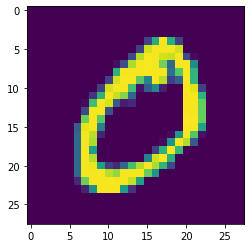

In [195]:
import matplotlib.pyplot as plt
plt.imshow(dataset.data[1].detach().numpy())
plt.show()

In [196]:
#loss
criterion = nn.CrossEntropyLoss()

In [197]:
# train loop
for epoch in tqdm(range(num_epoch)):
    #dataloder
    data_loader = DataLoader(dataset=dataset,
                             batch_size=batch_size,
                             shuffle=True,
                             collate_fn=collate_fn,
                             drop_last=True,
                             )
    for i, batch in enumerate(data_loader):
        optim.zero_grad()
        data = batch['data'].to(device).float()
        predict = model(data.unsqueeze(1))
        loss = criterion(predict, batch['target'].to(device))
        loss.backward()
        optim.step()
        if i % 100:
            print(loss)

  0%|          | 0/20 [00:00<?, ?it/s]

tensor(2.1852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1528, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4173, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2750, device='cuda:0', grad_fn=

  5%|▌         | 1/20 [00:12<04:04, 12.89s/it]

tensor(0.1167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0668, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1414, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0463, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0951, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1090, device='cuda:0', grad_fn=

 10%|█         | 2/20 [00:25<03:52, 12.89s/it]

tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0232, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0720, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0733, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0302, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0533, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0751, device='cuda:0', grad_fn=

 15%|█▌        | 3/20 [00:38<03:39, 12.91s/it]

tensor(0.0735, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0856, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0890, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0571, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0418, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0392, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0493, device='cuda:0', grad_fn=

 20%|██        | 4/20 [00:51<03:26, 12.93s/it]

tensor(0.0798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0169, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0145, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0391, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0362, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0528, device='cuda:0', grad_fn=

 25%|██▌       | 5/20 [01:04<03:14, 12.94s/it]

tensor(0.0577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0375, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0486, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0703, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0282, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0291, device='cuda:0', grad_fn=

 30%|███       | 6/20 [01:17<03:01, 12.95s/it]

tensor(0.0534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0473, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0389, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0330, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0077, device='cuda:0', grad_fn=

 35%|███▌      | 7/20 [01:30<02:48, 12.98s/it]

tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0350, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0552, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0513, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0116, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0280, device='cuda:0', grad_fn=

 40%|████      | 8/20 [01:43<02:35, 12.99s/it]

tensor(0.0620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0477, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0655, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0089, device='cuda:0', grad_fn=

 45%|████▌     | 9/20 [01:56<02:22, 12.99s/it]

tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0370, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0084, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1110, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0455, device='cuda:0', grad_fn=

 50%|█████     | 10/20 [02:09<02:10, 13.00s/it]

tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0264, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0225, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0258, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0456, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0630, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0071, device='cuda:0', grad_fn=

 55%|█████▌    | 11/20 [02:22<01:57, 13.01s/it]

tensor(0.0837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0449, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0215, device='cuda:0', grad_fn=

 60%|██████    | 12/20 [02:35<01:44, 13.01s/it]

tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0395, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0211, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=

 65%|██████▌   | 13/20 [02:48<01:31, 13.01s/it]

tensor(0.0425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0342, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0402, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0409, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0168, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0028, device='cuda:0', grad_fn=

 70%|███████   | 14/20 [03:01<01:17, 13.00s/it]

tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=

 75%|███████▌  | 15/20 [03:14<01:04, 12.99s/it]

tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0173, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0233, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0166, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0153, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=

 80%|████████  | 16/20 [03:27<00:51, 12.98s/it]

tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0053, device='cuda:0', grad_fn=

 85%|████████▌ | 17/20 [03:40<00:38, 12.97s/it]

tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0125, device='cuda:0', grad_fn=

 90%|█████████ | 18/20 [03:53<00:25, 12.97s/it]

tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0177, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0134, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=

 95%|█████████▌| 19/20 [04:06<00:12, 12.97s/it]

tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0143, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0180, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.1271e-05, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0119, device='cuda:0', grad

100%|██████████| 20/20 [04:19<00:00, 12.97s/it]

tensor(0.0311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0220, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)


In [198]:
torch.save(model.state_dict(), 'conv_model.pt')